In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)
from mcmodels.regressors import NadarayaWatson
import math

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from sklearn.kernel_ridge import KernelRidge

from mcmodels.core import Mask,ModelData,VoxelModelCache
from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
from mcmodels.utils import nonzero_unique, unionize
from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_regionalized_normalized_data
from mcmodels.core.utils import get_connectivity
from mcmodels.core.utils import get_ontological_order_leaf
from mcmodels.core.utils import get_nw_loocv,get_wt_inds
from mcmodels.core.utils import get_countvec
from mcmodels.core.utils import get_injection_hemisphere_id

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [3]:
def get_ccf_data(cache, experiment_id):

    eid_data = ExperimentData(experiment_id)
    eid_data.data_quality_mask = cache.get_data_mask(experiment_id)[0]
    eid_data.injection_signal = cache.get_injection_density(experiment_id)[0]
    eid_data.injection_fraction = cache.get_injection_fraction(experiment_id)[0]
    eid_data.projection_signal = cache.get_projection_density(experiment_id)[0]
    return(eid_data)
#     return {
#         "data_quality_mask" : cache.get_data_mask(experiment_id)[0],
#         "injection_signal" : cache.get_injection_density(experiment_id)[0],
#         "injection_fraction" : cache.get_injection_fraction(experiment_id)[0],
#         "projection_signal" : cache.get_projection_density(experiment_id)[0]
#     }

def get_connectivity_data(cache, structure_ids, experiments_exclude, remove_injection = False):

    connectivity_data = ConnectivityData()
    for sid in structure_ids:
        print(sid)
        sid_data = StructureData(sid)
        #deprecated language
        model_data = ModelData(cache, sid)
        sid_data.eids = model_data.get_experiment_ids(experiments_exclude=experiments_exclude, cre=None)
        for eid in sid_data.eids:
            
            eid_data = get_ccf_data(cache, eid)#ExperimentData(eid)
            eid_data.data_mask_tolerance = .5
            #ccf_data = get_ccf_data(cache, eid)
            eid_data.injection_signal_true = eid_data.injection_signal * eid_data.injection_fraction
            if remove_injection == True:
                pass #remove injection fraction from projection
            #injection_signal should = projection_signal in some locations (nonzero)
            #why do we use partial?
            #mask_func = partial(_mask_data_volume,data_mask=eid_data.data_mask,tolerance=eid_data.data_mask_tolerance)
            eid_data.injection_qmasked  = _mask_data_volume(eid_data.injection_signal_true,eid_data.data_quality_mask,eid_data.data_mask_tolerance)
            eid_data.projection_qmasked  = _mask_data_volume(eid_data.projection_signal,eid_data.data_quality_mask,eid_data.data_mask_tolerance) #mask_func(eid_data.projection_signal) 
            #eid_data.centroid = compute_centroid(eid_data.injection_qmasked)
            sid_data.experiment_datas[eid] = eid_data
        connectivity_data.structure_datas[sid] = sid_data
    return(connectivity_data)

def get_data_matrices(connectivity_data):
    
    structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    for sid in structure_ids:
        experiment_ids = np.asarray(list(connectivity_data.structure_datas[sid].experiment_datas.keys()))
        connectivity_data.structure_datas[sid].injection_mask = Mask.from_cache(cache,structure_ids=[sid],hemisphere_id=2)
        connectivity_data.structure_datas[sid].projection_mask = Mask.from_cache(cache,structure_ids=default_structure_ids, hemisphere_id=3)
        for eid in experiment_ids:
            connectivity_data.structure_datas[sid].experiment_datas[eid].injection_vec = connectivity_data.structure_datas[sid].injection_mask.mask_volume(connectivity_data.structure_datas[sid].experiment_datas[eid].injection_qmasked)
            connectivity_data.structure_datas[sid].experiment_datas[eid].projection_vec = connectivity_data.structure_datas[sid].projection_mask.mask_volume(connectivity_data.structure_datas[sid].experiment_datas[eid].projection_qmasked)
        connectivity_data.structure_datas[sid].injections = np.asarray([connectivity_data.structure_datas[sid].experiment_datas[eid].injection_vec for eid in connectivity_data.structure_datas[sid].eids])
        connectivity_data.structure_datas[sid].projections = np.asarray([connectivity_data.structure_datas[sid].experiment_datas[eid].projection_vec for eid in connectivity_data.structure_datas[sid].eids])
        connectivity_data.structure_datas[sid].centroids = np.asarray([connectivity_data.structure_datas[sid].experiment_datas[eid].centroid for eid in connectivity_data.structure_datas[sid].eids])
        
        
    return(connectivity_data)


def get_regionalized_normalized_data(connectivity_data, cache, source_order, ipsi_key, contra_key): #experiments_minor_structures):
    '''
    :param msvds: Class dictionary holding data
    :param cache: AllenSDK cache
    :param source_order: Source key (tautologically ipsilateral due to hemisphere mirroring)
    :param ipsi_key: Ipsilateral target key
    :param contra_key:  Contralateral target key
    :return: msvds: Class dictionary holding average data
    '''
    major_structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    for sid in major_structure_ids:
        # print()
        structure_data = connectivity_data.structure_datas[sid]
        #nexp = msvd.projections.shape[0]

        #minor_structures = np.unique(experiments_minor_structures[sid])
        #nmins = len(minor_structures)

        projections = structure_data.projections
        ipsi_proj = unionize(projections, ipsi_key)
        contra_proj = unionize(projections, contra_key)
        reg_proj = np.hstack([ipsi_proj, contra_proj])
        structure_data.reg_proj = reg_proj

        ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_key, return_counts=True)
        contra_target_regions, contra_target_counts = nonzero_unique(contra_key, return_counts=True)
        target_counts = np.concatenate([ipsi_target_counts, contra_target_counts])
        reg_proj_vcount_norm = np.divide(reg_proj, target_counts[np.newaxis, :])
        structure_data.reg_proj_vcount_norm = reg_proj_vcount_norm
        structure_data.reg_proj_vcount_norm_renorm = reg_proj_vcount_norm / np.expand_dims(np.linalg.norm(reg_proj_vcount_norm, axis=1), 1)
        
        source_mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=2)
        source_key = source_mask.get_key(structure_ids=source_order)
        source_regions, source_counts = nonzero_unique(source_key, return_counts=True)

        injections = structure_data.injections
        reg_ipsi_inj = unionize(injections, source_key)
        structure_data.reg_inj = reg_ipsi_inj
        reg_inj_vcount_norm = np.divide(reg_ipsi_inj, source_counts[np.newaxis, :])
        structure_data.reg_inj_vcount_norm = reg_inj_vcount_norm
        
        structure_data.reg_proj_vcount_norm_injnorm = reg_proj_vcount_norm / np.expand_dims(np.linalg.norm(reg_inj_vcount_norm, axis=1), 1)
        connectivity_data.structure_datas[sid] = structure_data
        #msvd.reg_proj_vcountnorm_totalnorm =

    return (connectivity_data)

# def get_normalized_data(connectivity_data, normalization = None):

#     structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
#     for sid in structure_ids:
#         if normalization == None:
#             pass
#         if normalization == 'injection':
#             nc = np.sum(connectivity_data.structure_datas[sid].injections, axis = 1)
#             connectivity_data.structure_datas[sid].projection_normed = connectivity_data.structure_datas[sid].projections / nc
#         if normalization == 'total':
#             nc = np.sum(conn_data[sid].projections, axis = 1)
#             connectivity_data.structure_datas[sid].projection_normed = connectivity_data.structure_datas[sid].projections / nc

#     return(connectivity_data)


def compute_centroid(injection_density):
    """Computes centroid in index coordinates.

    Parameters
    ----------
    injection_density : array, shape (x_ccf, y_ccf, z_ccf)
        injection_density data volume.

    Returns
    -------
        centroid of injection_density in index coordinates.
    """
    nnz = injection_density.nonzero()
    coords = np.vstack(nnz)

    return np.dot(coords, injection_density[nnz]) / injection_density.sum()

def get_cre_status(data_info, connectivity_data):
    major_structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    exps = np.asarray(data_info.index.values , dtype = np.int)
    creline = {}
    for sid in major_structure_ids:
        experiment_ids = np.asarray(list(connectivity_data.structure_datas[sid].experiment_datas.keys()))
        nexp = len(experiment_ids)
        creline[sid] = np.zeros(nexp, dtype = object)
        for i in range(len(experiment_ids)):
            index = np.where(exps == experiment_ids[i])[0][0]
            creline[sid][i] = data_info['transgenic-line'].iloc[index]
    return(creline)


In [4]:
class ConnectivityData():
    
    def __init__(self):
        self.structure_datas = {}    
    
    def get_injection_hemisphere_ids(self):
        
        structure_datas = self.structure_datas
        
        
        for sid in list(structure_datas.keys()):
            structure_datas[sid].get_injection_hemisphere_ids()
            
        self.structure_datas = structure_datas
        
        
    def align(self):
        
        structure_datas= self.structure_datas
        
        for sid in list(structure_datas.keys()):
            structure_datas[sid].align()
        self.structure_datas = structure_datas

    def get_centroids(self):
        
        structure_datas = self.structure_datas
        
        for sid in list(structure_datas.keys()):
            structure_datas[sid].get_centroids()
            
        self.structure_datas = structure_datas
        
class StructureData():
    
    def __init__(self, sid):
        self.experiment_datas = {}
        
    def get_injection_hemisphere_ids(self):   
        
        experiment_datas = self.experiment_datas
        
        for eid in list(experiment_datas.keys()):
             experiment_datas[eid].injection_hemisphere_id = get_injection_hemisphere_id(experiment_datas[eid].injection_qmasked, majority=True)
        self.experiment_datas = experiment_datas
        
    def align(self):
        
        experiment_datas = self.experiment_datas
        
        for eid in list(experiment_datas.keys()):
            if experiment_datas[eid].injection_hemisphere_id == 1:
                experiment_datas[eid].flip()
        self.experiment_datas = experiment_datas

    def get_centroids(self):
        
        experiment_datas = self.experiment_datas
        
        for eid in list(experiment_datas.keys()):
            experiment_datas[eid].centroid = compute_centroid(experiment_datas[eid].injection_qmasked)
        self.experiment_datas = experiment_datas        
        
class ExperimentData():
    
    def __init__(self, eid):
        2+2
    
    #def get_injection_hemisphere():
        
        
    def flip(self):
        """Reflects experiment along midline.

        Returns
        -------
        self - flipped experiment
        """

        self.injection_qmasked = self.injection_qmasked[..., ::-1]
        self.projection_qmasked = self.projection_qmasked[..., ::-1]
        self.injection_signal = self.injection_signal[..., ::-1]
        self.projection_signal = self.projection_signal[..., ::-1]
        self.injection_signal_true = self.injection_signal_true[..., ::-1]
        #self.projection_signal_true = self.projection_signal_true[..., ::-1]
        self.injection_fraction = self.injection_fraction[..., ::-1]
        self.data_quality_mask = self.data_quality_mask[...,::-1]
        
        #return self        

def _mask_data_volume(data_volume, data_mask, tolerance=0.0):
    """Masks a given data volume in place.

    Parameters
    ----------
    data_volume : array, shape (x_ccf, y_ccf, z_ccf)
        Data volume to be masked.

    data_mask : array, shape (x_ccf, y_ccf, z_ccf)
        data_mask for given experiment (values in [0,1])
        See allensdk.core.mouse_connectivity_cache for more info.

    tolerance : float, optional (default=0.0)
        tolerance with which to define bad voxels in data_mask.


    Returns
    -------
    data_volume
        data_volume parameter masked in place.

    """
    if data_volume.shape != data_mask.shape:
        raise ValueError("data_volume (%s) and data_mask (%s) must be the same "
                         "shape!" % (data_volume.shape, data_mask.shape))

    # mask data volume
    data_volume[data_mask < tolerance] = 0.0

    return data_volume


def get_summarystructure_dictionary(connectivity_data, data_info):
    summarystructure_dictionary = {}
    major_structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    for sid in major_structure_ids:
        eids = np.asarray(list(connectivity_data.structure_datas[sid].experiment_datas.keys()))
        summarystructure_dictionary[sid] = get_minorstructures(eids, data_info)
    return (summarystructure_dictionary)


def get_leaves_ontologicalorder(connectivity_data, ontological_order):
    '''

    :param msvd:
    :param ontological_order:
    :return: The leaf order associated with the 'ontological_order' of summary structures
    '''
    sid0 = list(connectivity_data.structure_datas.keys())[0]
    #eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]
    levs = connectivity_data.structure_datas[sid0].projection_mask.reference_space.structure_tree.child_ids(
        ontological_order)
    flat_list = np.asarray([item for sublist in levs for item in sublist])

    nss = len(levs)
    leavves = np.asarray([])
    for i in range(nss):
        if len(levs[i]) > 0:
            leavves = np.append(leavves, levs[i])
        else:
            leavves = np.append(leavves, ontological_order[i])
    return (leavves)

from sklearn.metrics.pairwise import pairwise_kernels
from mcmodels.regressors.nonparametric.nadaraya_watson import get_weights

def get_best_hyperparameters(losses, keys):
    
    major_structure_ids = np.asarray(list(losses.keys()))
    nms = len(major_structure_ids)
    nkey = keys.shape[1]
    output = np.empty((nms, nkey))
    for m in range(nms):
        print(m)
        sid = major_structure_ids[m]
        lvec = np.asarray([np.nanmean(losses[sid][key]) for key in keys])
        if np.any(~np.isnan(lvec)):
            output[m] = keys[np.nanargmin(lvec)]
        # if len(np.where(np.isnan(np.nanmean(losses[sid][:,:], axis = 1)))[0]) < losses[sid].shape[0]:
        #    output[m] = np.nanargmin(np.nanmean(losses[sid][:,:], axis = 1))

    output = np.asarray(output, dtype=int)
    return(output)

#get where we actually modelled
def get_eval_indices(eval_index_matrices):
    eval_indices = {}
    major_structure_ids = np.asarray(list(eval_index_matrices.keys()))
    for sid in major_structure_ids:
        eval_indices[sid] = np.where(eval_index_matrices[sid].sum(axis = 0) > 0)[0]
    return(eval_indices)    



def get_weights(eval_centroids, model_centroids, gamma):
    weights = pairwise_kernels(X=eval_centroids, Y=model_centroids, metric='rbf', gamma=gamma, filter_params=True)
    return (weights)


def get_indices(ids):

    ids_unique = np.unique(ids)
    output = np.zeros((len(ids_unique), len(ids)), dtype = int)
    for i in range(len(ids_unique)):
        output[i,np.where(ids == ids_unique[i])[0] ] = 1
    return(output)

#get indices of firstlist in firstlisttest in categories defined by secondlist
def get_indices2(firstlist, firstlisttest, secondlist):
    
    sl_unique = np.unique(secondlist)
    output = np.zeros((len(sl_unique), len(secondlist)), dtype = int)
    for i in range(len(sl_unique)):
        output[i,np.intersect1d(np.where(np.isin(firstlist,firstlisttest))[0], np.where(secondlist == sl_unique[i])[0])] = 1
    return(output)

#nmodels = nleafs
#populate each with experiments that share summary structure
def get_indices_summaryinleaf(summarylist , leaflist):
    
    nexp = len(leaflist)
    leaf_unique = np.unique(leaflist)
    output = np.zeros((len(leaf_unique), nexp), dtype = int)
    
    for i in range(len(leaf_unique)):
        
        summary = summarylist[np.where(leaflist == leaf_unique[i])[0]][0]
        output[i,np.where(summarylist == summary)[0]] = 1
        
        
    return(output)

#get predictions at all eval_indices using model_indices
#if an eval_indices is also a model indice, leave it out of the model
#if a model index is not an eval index, it never gets left out
def get_nwloocv_predictions_singlemodel(projections, centroids, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = pairwise_kernels(centroids[model_index_val], centroids[eval_index_val], metric='rbf', gamma=gamma, filter_params=True) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[:,i] / weights[:,i][otherindices].sum()
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

        
    return(predictions)    

def get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel(projections, centroids, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  

def combine_predictions(predictions, eval_index_matrix):
    
    nmodels, ngammas, nexp, ntargets = predictions.shape
    combined_predictions = np.empty((ngammas, nexp, ntargets))
    for m in range(nmodels):
        combined_predictions[:,np.where(eval_index_matrix[m] == 1)[0]] = predictions[m][:,np.where(eval_index_matrix[m] == 1)[0]]
        
    return(combined_predictions)

def get_nwloocv_predictions_multimodel_merge(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)

#we should not pass model_index_matrices that are identical to eval_index_matrices and have only 1 element per model
#although in principal we could do automatically in the cross validation code 
#we would rather do it explicitly to ensure identical indexing b/w experiments
#if we only have 1 model index we will remove the model index from eval indices
def screen_indices(model_indices, eval_indices):
    
    eval_indices2 = eval_indices.copy()
    mod_loc = np.where(model_indices == 1)[0]
    if len(mod_loc) == 1:
        eval_indices2[mod_loc] = 0
    return(eval_indices2)

#this could result in an empty eval index i.e. certain indices having no prediction.  catch later
#can merge (sum) the index matrix to see where predictions are actually generated
def screen_index_matrices(model_index_matrices, eval_index_matrices):
    
    #alter eval_indices to remove model index in cases where there is only one experiment in the model
    
    nmodels = model_index_matrices.shape[0]
    eval_index_matrices2 = eval_index_matrices.copy()
    for m in range(nmodels):
        eval_index_matrices2[m] = screen_indices(model_index_matrices[m], eval_index_matrices[m])
    
    return(eval_index_matrices2)

#need code for removing experiments that have no model
#this can happen when the model set is a subset of the evaluation set.
#we will therefore generate predictions for a subset
#given a leaf is included, the eval set is the same
#however, we want to remove evals in leaves we don't have a wt for... of course one could say we are doing worse...
#but we also have a fewer number of models
#model_index_matrices are the indices of the leafs'
#indices_wtinleaf are the wild types
#need to make sure we dont have leafs with only 1 experiment


def screen_index_matrices2(model_index_matrices, eval_index_matrices):
    
    #alter model and eval matrices to be nonzero only when there are at least two experiments in the model
    #it can be useful for when model_index_matrices is a subset of eval_index_matrices
    #nmodels = model_index_matrices.shape[0]
    include_per_model = model_index_matrices.sum(axis= 1)
    to_exclude = np.where(include_per_model <= 1)[0]
    #to_include = np.where(include_per_model > 0)[0]
    
    model_index_matrices2 = model_index_matrices.copy()
    eval_index_matrices2 = eval_index_matrices.copy()
    model_index_matrices2[to_exclude] = 0
    eval_index_matrices2[to_exclude] = 0
    
    return(model_index_matrices2, eval_index_matrices2)

def screen_index_matrices3(model_index_matrices, eval_index_matrices):
    
    #alter model and eval matrices to be nonzero only when there are at least one experiments in the model
    #it can be useful for when model_index_matrices is a subset of eval_index_matrices
    #nmodels = model_index_matrices.shape[0]
    include_per_model = model_index_matrices.sum(axis= 1)
    to_exclude = np.where(include_per_model < 1)[0]
    #to_include = np.where(include_per_model > 0)[0]
    
    model_index_matrices2 = model_index_matrices.copy()
    eval_index_matrices2 = eval_index_matrices.copy()
    model_index_matrices2[to_exclude] = 0
    eval_index_matrices2[to_exclude] = 0
    
    to_remove = np.where(include_per_model == 1)[0]
    eval_index_matrices2[to_remove] = 0
    
    return(model_index_matrices2, eval_index_matrices2)

def get_cre_similarity(proj, cres,eminors,colnames):

    ss = np.append(['cre','injsum'],colnames)
    ns = np.concatenate([np.empty(2, dtype = str), np.repeat('ipsi',291), np.repeat('contra',286)])
    colns = np.vstack([ns,ss]).transpose()
    clns = list(zip(*colns.transpose()))
    clnsmi = pd.MultiIndex.from_tuples(clns, names=['first', 'second'])
    data_merged = pd.DataFrame(np.hstack([np.expand_dims(cres,1),np.expand_dims(eminors,1),proj ]), columns= clnsmi)
    data_melted = pd.melt(data_merged, id_vars=[('','cre'),('','injsum')])
    data_melted = data_melted.astype({'value': np.float64})
    means = data_melted.groupby(by=['first', 'second',('','cre'),('','injsum')])['value'].mean().reset_index()
    means = means.astype({'value': np.float64})
    means_cast = pd.pivot_table(means, index = [('','cre'),('','injsum')], columns = ['first', 'second'])
    cs = np.asarray(list(means_cast.index))    
    return(means_cast,cs)

def get_cre_dist_cv(proj, means_cast, eminors,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        print(i)
        #get mean of all points sharing cre line and minor structure with this one (but not including)
        meani = means_cast.loc[tuple([cres[i], eminors[i]])]
#         ncr = len(np.where(cres == cres[i])[0])
        ls = np.where(leafs[sid] == leafs[sid][i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan
            
        #this was originally
        #print(meanloocvi.max(), 'max', ncr)

        #meanloocvi = meani
        #meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* msvd.reg_proj_vcount_norm_renorm[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        #rkeys = list(results[eminors[i]].keys())#np.asarray(list(results[experiments_minor_structures[sid][i]].keys()))
        for j in range(nsamp):
            meanj = means_cast.loc[tuple([cres[j], eminors[j]])]
            #t= tuple([cres[i], cres[j]])
            #if np.isin(t, rkeys).all():
            if eminors[j] == eminors[i]:
                credist[i,j]  = np.linalg.norm(meanloocvi - meanj)

    return(credist)

def get_nwloocv_predictions_singlemodel_dists(projections, dists, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = np.exp(-dists[model_index_val][:, eval_index_val] / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[i,:] / np.nansum(weights[i,:][otherindices])
            #print(np.nansum(weights[:,i][otherindices]))
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            weights_i[np.isnan(weights_i)] = 0.
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

        
    return(predictions) 

def get_nwloocv_predictions_multimodel_merge_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)
    
    
def get_nwloocv_predictions_multimodel_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel_dists(projections, dists, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  


In [5]:

connectivity_data = get_connectivity_data(cache, major_structure_ids[4:5], experiments_exclude, remove_injection = False)
connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()
#then apply the projection and injection masks to get regionalized data
connectivity_data = get_data_matrices(connectivity_data)

315


In [6]:


#major division segregation is legacy code but convenient for fast cross validation in major division model
experiments_minor_structures = get_summarystructure_dictionary(connectivity_data, data_info)

#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(connectivity_data, ontological_order)

#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
sid0 = list(connectivity_data.structure_datas.keys())[0]
eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]
#key = eid0

#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
#contra_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
#ipsi_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)
contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)

#get average intensities of projection structures given ipsi and contra keys
source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument


In [7]:
connectivity_data = get_regionalized_normalized_data(connectivity_data, cache, ontological_order, ipsi_targetkey, contra_targetkey)

In [8]:
creline = get_cre_status(data_info, connectivity_data)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)


In [9]:
indices_leaf = {}
indices_wtinleaf = {}
indices_wtleaf = {}
indices_summary = {}
indices_summaryinleaf = {}
indices_major = {}
indices_majorinleaf = {}
indices_leaf2ormore = {}
indices_wtinleaf2ormore = {}
indices_leaf_reduced = {}
indices_wtinleaf_reduced = {}
indices_wt_leaf2ormore = {}
indices_leaf2ormore_wt = {}
indices_wt1ormore_leaf2ormore = {}
indices_leaf2ormore_wt1ormore = {}
indices_creleaf = {}
indices_creleaf2ormore = {}
creleafs = {}
creleafs_merged = {}
for sid in major_structure_ids[4:5]:
    
    #wt_leaf on leaf

    #get the indices of experiments sharing leafs (nmodels is number of leafs)
    indices_leaf[sid] = get_indices(leafs[sid]) #eval_indices
    #indices_creleaf = get_indices(leafs[sid])
    
    #get the indices of the wts in the leaf (nmodels is number of leafs)
    indices_wtinleaf[sid] = get_indices2(creline[sid], np.asarray(['C57BL/6J']),leafs[sid]) #model_indices
    
    #get indices of experiments sharing summary structure x cre combination (nmodel is number of cre x leaf combinations)
    #indices_wtleaf[sid] = get_indices(creleafs_merged[sid])
    
    #get indices of experiments sharing summary structure(nmodel is number of summary structures)
    #indices_summary[sid] = get_indices(experiments_minor_structures[sid])
    
    #get indices of experiments sharing major structure(nmodel is number of summary structures)
    #indices_major[sid] = np.ones((1,experiments_minor_structures[sid].shape[0]))
    
    #get indices of experiments sharing same major structure as a leaf (nmodel is number of leafs)
    #indices_majorinleaf[sid] = np.ones((len(np.unique(leafs[sid])),experiments_minor_structures[sid].shape[0]))#get_indices2(np.ones(len(leafs[sid])), np.asarray([1]),leafs[sid]) #model_indices
    
    #get indices of experiments in same summary structure as a leaf (nmodel is number of leafs)
    #indices_summaryinleaf[sid] = get_indices_summaryinleaf(experiments_minor_structures[sid], leafs[sid])
    
    #evaluate models on leafs
    indices_leaf2ormore[sid] = screen_index_matrices(indices_leaf[sid], indices_leaf[sid])
    
    indices_wt1ormore_leaf2ormore[sid], indices_leaf2ormore_wt1ormore[sid] = screen_index_matrices3(indices_wtinleaf[sid], indices_leaf2ormore[sid])
    
    indices_wtinleaf2ormore[sid] = screen_index_matrices(indices_wtinleaf[sid], indices_wtinleaf[sid])
    indices_leaf_reduced[sid], indices_wtinleaf_reduced[sid]  = screen_index_matrices2( indices_leaf2ormore[sid],indices_wtinleaf[sid])


    #for sid in major_structure_ids:
    creleafs[sid] = np.asarray(np.vstack([leafs[sid], creline[sid]]), dtype = str).transpose()
    creleafs_merged[sid] = [creleafs[sid][:,0][i]  + creleafs[sid][:,1][i] for i in range(creleafs[sid].shape[0])]
    

    #for sid in major_structure_ids:
    indices_creleaf[sid] = get_indices(np.asarray(creleafs_merged[sid]))
    indices_creleaf2ormore[sid] = screen_index_matrices(indices_creleaf[sid], indices_creleaf[sid])

eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)

In [10]:
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)
target_order = lambda x: np.array(ontological_order)[np.isin(ontological_order, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])
colnames = np.asarray([ia_map[targ_ids[i]] for i in range(len(targ_ids))])

In [11]:

def get_loss_surface_control(proj,centroids,fraction,creline_sid,leafs_sid):
    nsamp = centroids.shape[0]
    #need source and target color
    source = np.repeat(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
    target = np.tile(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
    gp = np.zeros((nsamp, nsamp))
    for i in range(nsamp):
        for j in range(nsamp):
            if creline_sid[i] == creline_sid[j]:
                if leafs_sid[i] == leafs_sid[j]:
                    gp[i,j] = 1
    goodpairs = np.asarray(np.where(gp == 1)).transpose()
    ngp = goodpairs.shape[0]
    projs = proj
    ds2 = np.zeros(ngp)
    ls2 = np.zeros(ngp)
    for i in range(ngp):
        ds2[i] = np.linalg.norm(centroids[goodpairs[i][0]] - centroids[goodpairs[i][1]])**2
        
        ls2[i] = np.linalg.norm(projs[goodpairs[i][0]] - projs[goodpairs[i][1]])**2
    dsnorm  = np.linalg.norm(ds2)
    ds2 = ds2 / dsnorm
    dc = np.asarray([ds2,ls2]).transpose()
    qqq = NadarayaWatson(kernel='rbf',  gamma  = 200000)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    qqq.fit(dc[:,:1][randos], dc[:,1:][randos])
    
    return(qqq)


In [12]:
#wrong dist (not remove)... try to recreate old result
frac_learn = np.ones(12)
frac_learn[4] = .01
sls = {}
for m in range(4,5):
    sid = major_structure_ids[m]#[np.asarray([0,1,2,3,4,5,6,7,8,9,10,11], dtype = int)]:
    print(sid)
    #msvd = msvds[sid]
    cres = creline[sid]
    eminors = leafs[sid]
    #means_cast, cs = get_cre_similarity(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, cres,eminors, colnames)
    #cre_dist2 = get_cre_dist_cv(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, means_cast, eminors,cres)
    qqq = get_loss_surface_control(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, connectivity_data.structure_datas[sid].centroids,frac_learn[m],creline[sid],leafs[sid])


315


(0, 0.01)

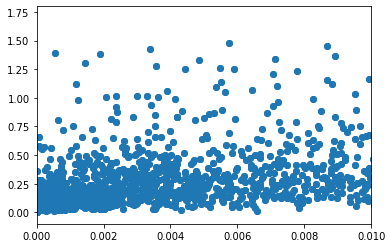

In [14]:

proj = connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm
centroids = connectivity_data.structure_datas[sid].centroids
fraction = frac_learn[m]
creline_sid = creline[sid]
leafs_sid = leafs[sid]
nsamp = centroids.shape[0]
#need source and target color
source = np.repeat(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
target = np.tile(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
gp = np.zeros((nsamp, nsamp))
for i in range(nsamp):
    for j in range(nsamp):
        if creline_sid[i] == creline_sid[j]:
            if leafs_sid[i] == leafs_sid[j]:
                gp[i,j] = 1
goodpairs = np.asarray(np.where(gp == 1)).transpose()
ngp = goodpairs.shape[0]
projs = proj
ds2 = np.zeros(ngp)
ls2 = np.zeros(ngp)
for i in range(ngp):
    ds2[i] = np.linalg.norm(centroids[goodpairs[i][0]] - centroids[goodpairs[i][1]])**2
    ls2[i] = np.linalg.norm(projs[goodpairs[i][0]] - projs[goodpairs[i][1]])**2
dsnorm  = np.linalg.norm(ds2)
ds2 = ds2 / dsnorm
dc = np.asarray([ds2,ls2]).transpose()
plt.scatter(dc[:,0], dc[:,1])
plt.xlim(0,0.01)

Text(0, 0.5, 'Projection distance predicted')

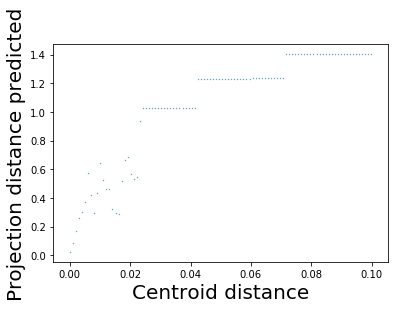

In [35]:
qqq = NadarayaWatson(kernel='rbf',  gamma  = 1000000)
#qqq = KernelRidge(kernel='rbf', alpha=0, gamma  = .05)
randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
qqq.fit(dc[:,:1][randos], dc[:,1:][randos])
xs = np.linspace(0, dc[:,0].max(), 100)
#ys = np.linspace(0, dc[:,1].max(), 100)
preds = np.empty((100))
for x in range(100):
    preds[x] =qqq.predict(np.asarray([xs[x]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))
#mxy = np.asarray(np.meshgrid(xs,ys)).transpose()
fig,ax = plt.subplots(1,1)
ax.scatter(xs, preds, s= .1)
ax.set_xlabel('Centroid distance', fontsize=20)
ax.set_ylabel('Projection distance predicted', fontsize=20)

In [43]:
def get_smoothed_losses_control(proj,centroids,fraction,creline_sid,leafs_sid):
    
    nsamp = centroids.shape[0]
    #need source and target color
    source = np.repeat(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
    target = np.tile(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
    gp = np.zeros((nsamp, nsamp))
    for i in range(nsamp):
        for j in range(nsamp):
            if creline_sid[i] == creline_sid[j]:
                if leafs_sid[i] == leafs_sid[j]:
                    gp[i,j] = 1
                 
    goodpairs = np.asarray(np.where(gp == 1)).transpose()
    ds = pairwise_distances(centroids)**2

    nsamp = ds.shape[0]
    smoothedlosses = np.empty((nsamp,nsamp))
    smoothedlosses[:] = np.nan
    
    ds2 = np.zeros(ngp)
    for i in range(ngp):
        ds2[i] = ds[goodpairs[i,0], goodpairs[i,1]]
    dsnorm  = np.linalg.norm(ds2)

    ds2 = ds2 / dsnorm
    
    for i in range(ngp):#np.linalg.norm(centroids[goodpairs[i][0]] - centroids[goodpairs[i][1]])**2
        smoothedlosses[goodpairs[i,0], goodpairs[i,1]] = qqq.predict(np.asarray([ds2[i]])) #np.linalg.norm(projs[goodpairs[i][0]] - projs[goodpairs[i][1]])**2
        #print(ds2[i], smoothedlosses[goodpairs[i,0], goodpairs[i,1]])


    return(smoothedlosses)

In [44]:
    sls_control = {}
    sls_control[sid] = get_smoothed_losses_control(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, connectivity_data.structure_datas[sid].centroids,fraction,creline[sid],leafs[sid])

In [45]:
#sls_control[sid] [2][:1000]

In [46]:

#     nsamp = centroids.shape[0]
#     #need source and target color
#     source = np.repeat(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
#     target = np.tile(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
#     gp = np.zeros((nsamp, nsamp))
#     for i in range(nsamp):
#         for j in range(nsamp):
#             if creline_sid[i] == creline_sid[j]:
#                 if leafs_sid[i] == leafs_sid[j]:
#                     gp[i,j] = 1
                 
#     goodpairs = np.asarray(np.where(gp == 1)).transpose()
#     ds = pairwise_distances(centroids)**2
#     #ds2 = ds[goodpairs]
#     #dsnorm  = np.linalg.norm(ds2)
#     ls = pairwise_distances(proj)**2
#     nsamp = ds.shape[0]
#     smoothedlosses = np.empty((nsamp,nsamp))
#     smoothedlosses[:] = np.nan
#     for i in range(goodpairs.shape[0]):
#         #ci = cs[bbbb[i,0], bbbb[i,1]] / csnorm
        
#         di = ds[goodpairs[i,0], goodpairs[i,1]] / dsnorm
#         print(di, qqq.predict(np.asarray([di])))
#         smoothedlosses[goodpairs[i,0], goodpairs[i,1]] = qqq.predict(np.asarray([di]))


In [47]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids[4:5]:
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, 
                                                                                       sls_control[sid], 
                                                                                       gammas, 
                                                                                       indices_creleaf2ormore[sid], 
                                                                                       indices_creleaf2ormore[sid])
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids[4:5]:
    reg_proj_vcount_norm_renorms[sid ] = connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2

eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)
losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

(620, 5, 1128, 577)
0


In [48]:
losses_leaf_leaf2[315] #[:,1] is worse than centroid only at gamma = 200000

array([[0.27214122, 0.4739557 , 0.42313107, ..., 0.06492651, 0.2599173 ,
        0.73011268],
       [0.27214122, 0.52240207, 0.42829346, ..., 0.06995269, 0.2599173 ,
        0.61593079],
       [0.27214122, 0.57021739, 0.42902701, ..., 0.07726793, 0.2599173 ,
        0.64563718],
       [0.27214122, 0.60097991, 0.42939872, ..., 0.08299022, 0.2599173 ,
        0.67443383],
       [0.27214122, 0.62702639, 0.42969824, ..., 0.08894389, 0.2599173 ,
        0.70460058]])

In [54]:
sls_control[sid][eval_indices_creleaf2ormore[315][1]][:1000]

array([       nan,        nan, 0.0240286 ,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

2

In [41]:
meanloss_nw_leaf_leaf2

array([0.29962911])

In [22]:
meanloss_nw_leaf_leaf2

array([0.30222913])

In [24]:
pds = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2

In [179]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids[4:5]:
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, 
                                                                                       pds, 
                                                                                       gammas, 
                                                                                       indices_creleaf2ormore[sid], 
                                                                                       indices_creleaf2ormore[sid])
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids[4:5]:
    reg_proj_vcount_norm_renorms[sid ] = connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2

# eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)
# losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
# best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
# meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)
losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in true_divide


(620, 5, 1128, 577)
0


In [180]:
#losses_leaf_leaf2[315]  = 0.

In [181]:
lsave = losses_leaf_leaf2[315] + 0.

In [182]:
lsave

array([[0.27214122, 0.42440166, 0.42318851, ..., 0.06707866, 0.2599173 ,
        0.64170026],
       [0.27214122, 0.42440602, 0.42405743, ..., 0.06228889, 0.2599173 ,
        0.64167633],
       [0.27214122, 0.42440602, 0.4240574 , ..., 0.07484195, 0.2599173 ,
        0.64167633],
       [0.27214122, 0.42440602, 0.4240574 , ..., 0.08480845, 0.2599173 ,
        0.64167633],
       [0.27214122, 0.42440602, 0.4240574 , ..., 0.08626172, 0.2599173 ,
        0.64167633]])

In [183]:
best_gamma_leaf_leaf2

array([[0]])

In [184]:
meanloss_nw_leaf_leaf2

array([0.30072493])

In [14]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids[4:5]:
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, 
                                                                                       connectivity_data.structure_datas[sid].centroids, 
                                                                                       gammas, 
                                                                                       indices_creleaf2ormore[sid], 
                                                                                       indices_creleaf2ormore[sid])
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids[4:5]:
    reg_proj_vcount_norm_renorms[sid ] = connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2

eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)
losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/e

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/e

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_0

(620, 5, 1128, 577)
0


In [16]:
meanloss_nw_leaf_leaf2

array([0.30072493])

In [21]:
np.nanmean(losses_leaf_leaf2[sid][4, :])

0.5605442302247133

In [31]:
connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm

array([[4.54800748e-04, 1.09955085e-05, 0.00000000e+00, ...,
        5.32004325e-03, 0.00000000e+00, 1.00041031e-02],
       [5.13135617e-03, 1.61887743e-05, 3.59820044e-05, ...,
        0.00000000e+00, 0.00000000e+00, 9.42252256e-06],
       [6.62649293e-02, 7.91556591e-03, 0.00000000e+00, ...,
        1.86573792e-02, 2.07420761e-03, 8.00850086e-03],
       ...,
       [1.34075847e-03, 1.67553618e-04, 1.03449002e-06, ...,
        2.76405562e-04, 5.04454827e-05, 1.77023763e-04],
       [2.39921370e-02, 7.11895954e-05, 1.44303559e-05, ...,
        3.58883721e-02, 1.12431083e-02, 2.47221686e-02],
       [5.72316777e-03, 1.61017580e-06, 4.04545904e-05, ...,
        1.30635375e-04, 5.00576333e-05, 2.58944283e-04]])

In [68]:
np.where(np.isnan(losses_leaf_leaf2[315])) #theres nans in losses_leaf_leaf2[315] but not in _dists

(array([], dtype=int64), array([], dtype=int64))

In [17]:
np.where(np.isnan(connectivity_data.structure_datas[315].loocv_predictions_leaf_leaf2))

(array([3, 3, 3, ..., 4, 4, 4]),
 array([  61,   61,   61, ..., 1115, 1115, 1115]),
 array([  0,   1,   2, ..., 574, 575, 576]))

In [13]:
np.where(np.isnan(get_nwloocv_predictions_multimodel_merge(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, 
                                                                                       connectivity_data.structure_datas[sid].centroids, 
                                                                                       gammas, 
                                                                                       indices_creleaf2ormore[sid], 
                                                                                       indices_creleaf2ormore[sid])))

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaco

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaco

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: overflow encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: overflow encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/a

(620, 5, 1128, 577)


(array([3, 3, 3, ..., 4, 4, 4]),
 array([  61,   61,   61, ..., 1115, 1115, 1115]),
 array([  0,   1,   2, ..., 574, 575, 576]))

In [163]:
#np.intersect1d(np.where(creline_sid == creline_sid[42])[0],np.where(leafs_sid == leafs_sid[42])[0])
#connectivity_data.structure_datas[315].reg_proj_vcount_norm_renorm.shape
#connectivity_data.structure_datas[315].reg_proj_vcount_norm_renorm.shape
#eval_indices_creleaf2ormore[315].shape, indices_creleaf2ormore[315].shape #nwloocv_leaf_leaf2[315][4,42]
#losses_leaf_leaf2[315][4,42], eval_indices_creleaf2ormore[315][42]

array([  40,   42,   76,  126,  155,  200,  245,  333,  534,  583,  605,
        682,  889, 1008])

In [31]:
nwloocv_leaf_leaf2[315][4,61][:5], nwloocv_leaf_leaf2[315].shape

(array([nan, nan, nan, nan, nan]), (5, 1128, 577))

In [32]:
indices_creleaf2ormore[sid].shape , np.asarray(np.where(indices_creleaf2ormore[sid][:,61] == 1)).transpose()

((620, 1128), array([[428]]))

In [37]:
projections = connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm
centroids = connectivity_data.structure_datas[sid].centroids
dists = pds
gamma = gammas[4]
model_index_matrix = indices_creleaf2ormore[sid]
eval_index_matrix = indices_creleaf2ormore[sid]
model_indices = [428]
eval_indices = indices_creleaf2ormore[sid][428] #results are different for which index?

In [34]:
predictions_unmerged = get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix)
print(predictions_unmerged.shape)
predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaco

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaco

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: overflow encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: overflow encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/a

(620, 5, 1128, 577)


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: invalid value encountered in true_divide


In [36]:
predictions_merged[:,61]

array([[1.07484851e-02, 1.77033944e-04, 3.64117883e-03, ...,
        1.72572036e-04, 1.59473567e-18, 1.62325962e-03],
       [1.07484851e-02, 1.77033944e-04, 3.64117883e-03, ...,
        1.72572036e-04, 0.00000000e+00, 1.62325962e-03],
       [1.07484851e-02, 1.77033944e-04, 3.64117883e-03, ...,
        1.72572036e-04, 0.00000000e+00, 1.62325962e-03],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])

In [187]:
nwloocv_leaf_leaf2[315][4,61]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [177]:
lsave

0.0

In [167]:
losses_leaf_leaf2[315].shape #its the 4,42 in here thats the issue...

(5, 732)

In [156]:
best_gamma_leaf_leaf2

array([[4]])

In [145]:
losses_leaf_leaf2[315].shape

(5, 732)

In [143]:
np.where(np.isnan(lsave))

(array([], dtype=int64), array([], dtype=int64))

In [144]:
lsave

array([[0.27214122, 0.42440166, 0.42318851, ..., 0.06707866, 0.2599173 ,
        0.64170026],
       [0.27214122, 0.42440602, 0.42405743, ..., 0.06228889, 0.2599173 ,
        0.64167633],
       [0.27214122, 0.42440602, 0.4240574 , ..., 0.07484195, 0.2599173 ,
        0.64167633],
       [0.27214122, 0.42440602, 0.4240574 , ..., 0.08480845, 0.2599173 ,
        0.64167633],
       [0.27214122, 0.42440602, 0.4240574 , ..., 0.08626172, 0.2599173 ,
        0.64167633]])

In [140]:
np.nanmin(losses_leaf_leaf2[315] - lsave)

0.0

In [13]:

#get predictions at all eval_indices using model_indices
#if an eval_indices is also a model indice, leave it out of the model
#if a model index is not an eval index, it never gets left out
def get_nwloocv_predictions_singlemodel(projections, centroids, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = pairwise_kernels(centroids[model_index_val], centroids[eval_index_val], metric='rbf', gamma=gamma, filter_params=True) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[:,i] / weights[:,i][otherindices].sum()
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            
            weights_i[np.isnan(weights_i)] = 0.
            
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

        
    return(predictions)    

def get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel(projections, centroids, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  

def combine_predictions(predictions, eval_index_matrix):
    
    nmodels, ngammas, nexp, ntargets = predictions.shape
    combined_predictions = np.empty((ngammas, nexp, ntargets))
    for m in range(nmodels):
        combined_predictions[:,np.where(eval_index_matrix[m] == 1)[0]] = predictions[m][:,np.where(eval_index_matrix[m] == 1)[0]]
        
    return(combined_predictions)

def get_nwloocv_predictions_multimodel_merge(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)

#we should not pass model_index_matrices that are identical to eval_index_matrices and have only 1 element per model
#although in principal we could do automatically in the cross validation code 
#we would rather do it explicitly to ensure identical indexing b/w experiments
#if we only have 1 model index we will remove the model index from eval indices

def get_nwloocv_predictions_singlemodel_dists(projections, dists, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = np.exp(-dists[model_index_val][:, eval_index_val] * gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[i,:] / np.nansum(weights[i,:][otherindices])
            #print(np.nansum(weights[:,i][otherindices]))
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            weights_i[np.isnan(weights_i)] = 0.
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

        
    return(predictions) 

def get_nwloocv_predictions_multimodel_merge_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)
    
    
def get_nwloocv_predictions_multimodel_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel_dists(projections, dists, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  


In [188]:
indices_creleaf2ormore[sid].shape #why do we have 620 models??

(620, 1128)

In [212]:
np.asarray(np.where(indices_creleaf2ormore[sid][:,61] == 1)).transpose()

array([[428]])

In [19]:
pds = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2

In [38]:
projections = connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm
centroids = connectivity_data.structure_datas[sid].centroids
dists = pds
gamma = gammas[4]
model_indices = indices_creleaf2ormore[sid][428]
eval_indices = indices_creleaf2ormore[sid][428] #results are different for which index?

In [58]:
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = pairwise_kernels(centroids[model_index_val], centroids[eval_index_val], metric='rbf', gamma=gamma, filter_params=True) #get_weights(centroids, gamma)
        #for i in range(neval):
        i  = 0 
        matchindex = np.where(model_index_val == eval_index_val[i])[0]
        otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
        #this order of operations is the fastest I found
        weights_i = weights[:,i] / weights[:,i][otherindices].sum()
        weights_i[matchindex] = 0
        weights_i = np.asarray(weights_i, dtype=np.float32)
        pred = np.dot(weights_i, projections[model_index_val])
        #predictions[eval_index_val[i]] = pred


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [60]:
weights

array([[1.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 1.00000000e+000, 1.15652978e-216],
       [0.00000000e+000, 1.15652978e-216, 1.00000000e+000]])

In [59]:
pred

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [225]:
dists[61]

array([2060.36638465, 4309.53972985,  357.7903016 , ..., 3221.02208087,
       1842.34638847,  115.01840761])

In [226]:
#eval_indices_creleaf2ormore[315][1] #this is the 1 model

In [227]:
#np.where(np.asarray(np.where(indices_creleaf2ormore[315] ==1)).transpose()[:,1] == 2)[0]

In [228]:
# for i in range(620):
#     print(len(np.where(indices_creleaf2ormore[sid][i] == 1)[0]))

In [61]:
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = np.exp(-dists[model_index_val][:, eval_index_val] * gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
        i = 0
        #for i in range(neval):
        matchindex = np.where(model_index_val == eval_index_val[i])[0]
        otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
        #this order of operations is the fastest I found
        weights_i = weights[i,:] / np.nansum(weights[i,:][otherindices])
        #print(np.nansum(weights[:,i][otherindices]))
        weights_i[matchindex] = 0
        weights_i = np.asarray(weights_i, dtype=np.float32)
        #weights_i[np.isnan(weights_i)] = 0.
        pred = np.dot(weights_i, projections[model_index_val])
        #predictions[eval_index_val[i]] = pred

#         i  = 0 
#         matchindex = np.where(model_index_val == eval_index_val[i])[0]
#         otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
#         #this order of operations is the fastest I found
#         weights_i = weights[:,i] / weights[:,i][otherindices].sum()
#         weights_i[matchindex] = 0
#         weights_i = np.asarray(weights_i, dtype=np.float32)
#         pred = np.dot(weights_i, projections[model_index_val])
        

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [62]:
pred

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [55]:
weights = np.exp(-dists[model_index_val][:, eval_index_val] * gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
print(weights)
i = 0
#for i in range(neval):
matchindex = np.where(model_index_val == eval_index_val[i])[0]
otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
#this order of operations is the fastest I found
weights_i = weights[i,:] / np.nansum(weights[i,:][otherindices])
#print(np.nansum(weights[:,i][otherindices]))
weights_i[matchindex] = 0
weights_i = np.asarray(weights_i, dtype=np.float32)
weights_i[np.isnan(weights_i)] = 0.
pred = np.dot(weights_i, projections[model_index_val])
#predictions[eval_index_val[i]] = pred


[[1.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.00000000e+000 1.15652978e-216]
 [0.00000000e+000 1.15652978e-216 1.00000000e+000]]


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [53]:
weights_i

array([0., 0., 0.], dtype=float32)

In [217]:
weights

array([[1.00000000e+00, 6.34921906e-35, 2.79361114e-21],
       [6.34921906e-35, 1.00000000e+00, 6.92837791e-03],
       [2.79361114e-21, 6.92837791e-03, 1.00000000e+00]])

In [218]:
weights = pairwise_kernels(centroids[model_index_val], centroids[eval_index_val], metric='rbf', gamma=gamma, filter_params=True) #get_weights(centroids, gamma)

In [219]:
weights

array([[1.00000000e+00, 6.34921906e-35, 2.79361114e-21],
       [6.34921906e-35, 1.00000000e+00, 6.92837791e-03],
       [2.79361114e-21, 6.92837791e-03, 1.00000000e+00]])

In [235]:
    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = pairwise_kernels(centroids[model_index_val], centroids[eval_index_val], metric='rbf', gamma=gamma, filter_params=True) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[:,i] / weights[:,i][otherindices].sum()
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

      

In [239]:
eval_index_val[i]

646

In [238]:
pred

array([3.19379324e-04, 1.24613777e-07, 1.37666609e-23, 2.56526946e-05,
       1.16039478e-09, 6.04225323e-02, 1.17273543e-04, 2.42399993e-22,
       0.00000000e+00, 0.00000000e+00, 6.00158119e-24, 7.24503458e-01,
       6.00208677e-02, 2.54190117e-01, 2.64602294e-03, 1.12820953e-21,
       0.00000000e+00, 1.21839912e-24, 1.97549703e-22, 0.00000000e+00,
       8.42131420e-23, 0.00000000e+00, 6.60718579e-05, 1.42331442e-06,
       3.30977229e-04, 3.68915676e-06, 3.12435208e-04, 0.00000000e+00,
       8.40789347e-04, 0.00000000e+00, 1.74732967e-24, 3.57613526e-03,
       2.51003657e-04, 2.39593089e-02, 2.37598599e-08, 1.25790160e-04,
       0.00000000e+00, 0.00000000e+00, 2.27920296e-24, 0.00000000e+00,
       0.00000000e+00, 1.54742813e-23, 2.98130838e-03, 2.28280202e-03,
       3.16300808e-04, 7.45197959e-23, 6.74499740e-25, 2.99068270e-05,
       2.08152278e-23, 0.00000000e+00, 1.13510687e-04, 5.98738516e-05,
       7.12338602e-03, 1.55936754e-23, 6.27245987e-04, 1.29332126e-04,
      

In [ ]:
nwloocv_leaf_leaf2[315][4,61]

In [27]:

def get_nwloocv_predictions_singlemodel_dists_near(projections, dists, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = np.exp(-dists[model_index_val][:, eval_index_val] * gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[i,:] / np.nansum(weights[i,:][otherindices])
            #print(np.nansum(weights[:,i][otherindices]))
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            weights_i[np.isnan(weights_i)] = 0.
            if np.sum(weights_i) > 0.:
                #print('here')
                pred = np.dot(weights_i, projections[model_index_val])
            else:
                print('here')
                am = np.argmin(dists[model_index_val[otherindices]][:, eval_index_val[i]])
                pred = projections[model_index_val[otherindices[am]]]
            predictions[eval_index_val[i]] = pred

        
    return(predictions) 

def get_nwloocv_predictions_multimodel_merge_dists_near(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel_dists_near(projections, dists, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)
    
    
def get_nwloocv_predictions_multimodel_dists_near(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel_dists_near(projections, dists, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  

In [43]:

def get_nwloocv_predictions_singlemodel_dists_av(projections, dists, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = np.exp(-dists[model_index_val][:, eval_index_val] * gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[i,:] / np.nansum(weights[i,:][otherindices])
            #print(np.nansum(weights[:,i][otherindices]))
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            weights_i[np.isnan(weights_i)] = 0.
            if np.sum(weights_i) > 0.:
                #print('here')
                pred = np.dot(weights_i, projections[model_index_val])
            else:
                print('here')
                #am = np.argmin(dists[model_index_val[otherindices]][:, eval_index_val[i]])
                pred = np.mean(projections[model_index_val[otherindices]], axis = 0)
            predictions[eval_index_val[i]] = pred

        
    return(predictions) 

def get_nwloocv_predictions_multimodel_merge_dists_av(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel_dists_av(projections, dists, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)
    
    
def get_nwloocv_predictions_multimodel_dists_av(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel_dists_av(projections, dists, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  

In [46]:

def get_nwloocv_predictions_singlemodel_dists_factor(projections, dists, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        ds =dists[model_index_val][:, eval_index_val]
        dmin = ds[np.argsort(ds)]
        ds = ds - dmin
        weights = np.exp(- ds * gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[i,:] / np.nansum(weights[i,:][otherindices])
            #print(np.nansum(weights[:,i][otherindices]))
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            weights_i[np.isnan(weights_i)] = 0.
            if np.sum(weights_i) > 0.:
                #print('here')
                pred = np.dot(weights_i, projections[model_index_val])
            else:
                print('here')
                #am = np.argmin(dists[model_index_val[otherindices]][:, eval_index_val[i]])
                pred = np.mean(projections[model_index_val[otherindices]], axis = 0)
            predictions[eval_index_val[i]] = pred

        
    return(predictions) 

def get_nwloocv_predictions_multimodel_merge_dists_factor(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel_dists_factor(projections, dists, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)
    
    
def get_nwloocv_predictions_multimodel_dists_factor(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel_dists_factor(projections, dists, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  

In [ ]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids[4:5]:
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists_av(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, 
                                                                                       pds, 
                                                                                       gammas, 
                                                                                       indices_creleaf2ormore[sid], 
                                                                                       indices_creleaf2ormore[sid])
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids[4:5]:
    reg_proj_vcount_norm_renorms[sid ] = connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2

# eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)
# losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
# best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
# meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)
losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

In [39]:
np.argsort(np.asarray([1,2,3,4]))

array([0, 1, 2, 3])

In [44]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids[4:5]:
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists_av(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, 
                                                                                       pds, 
                                                                                       gammas, 
                                                                                       indices_creleaf2ormore[sid], 
                                                                                       indices_creleaf2ormore[sid])
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids[4:5]:
    reg_proj_vcount_norm_renorms[sid ] = connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2

# eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)
# losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
# best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
# meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)
losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in true_divide


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
(620, 5, 1128, 577)
0


In [47]:
meanloss_nw_leaf_leaf2

array([0.30072493])

In [35]:
np.mean(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm[[0,1]], axis = 0).shape

(577,)

In [28]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids[4:5]:
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists_near(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, 
                                                                                       pds, 
                                                                                       gammas, 
                                                                                       indices_creleaf2ormore[sid], 
                                                                                       indices_creleaf2ormore[sid])
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids[4:5]:
    reg_proj_vcount_norm_renorms[sid ] = connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2

# eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)
# losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
# best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
# meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)
losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in true_divide


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
(620, 5, 1128, 577)
0


In [29]:
meanloss_nw_leaf_leaf2

array([0.30072493])

In [30]:
np.nanmean(losses_leaf_leaf2[sid][4, :])

0.3202595919320931